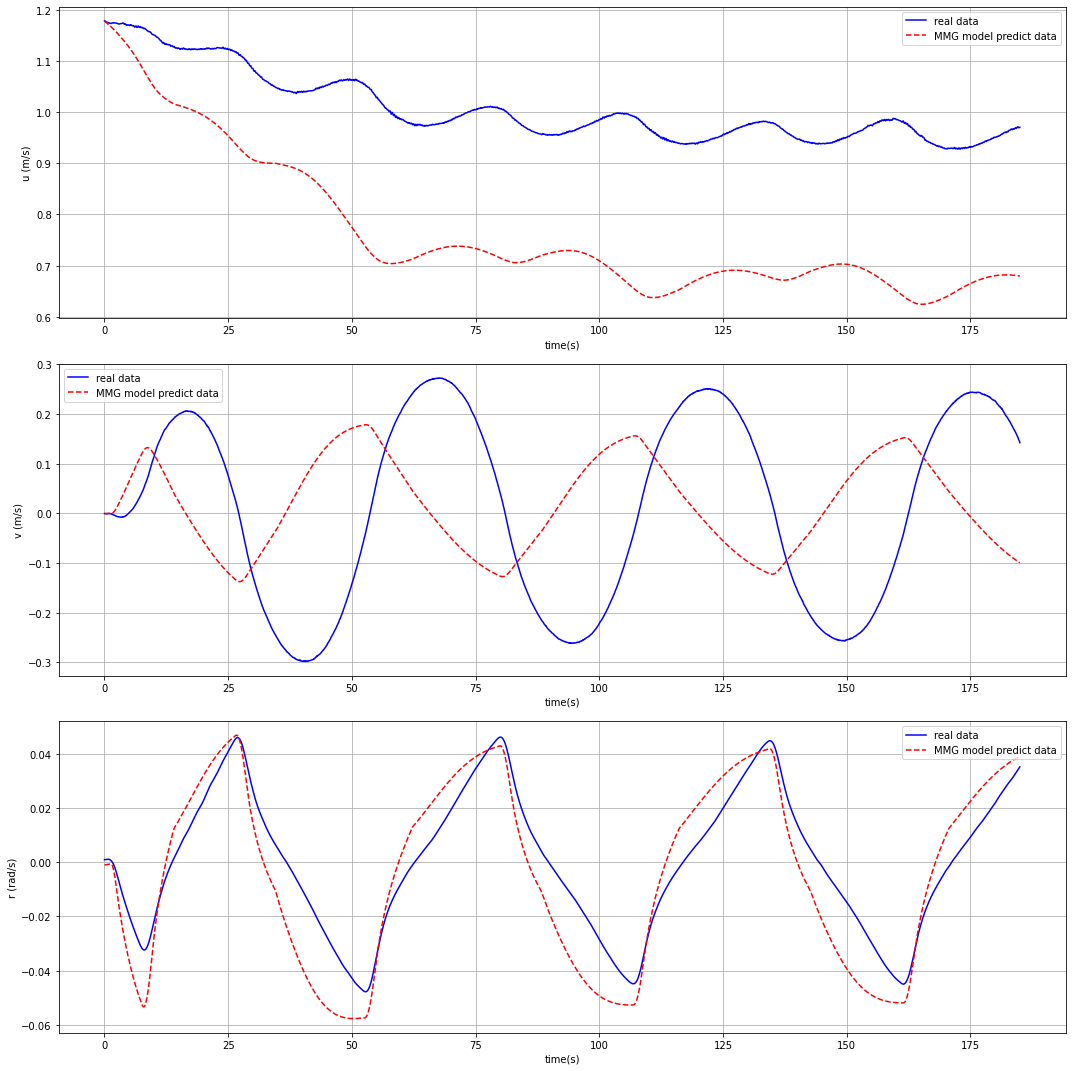

纵向速度 u RMSE: 0.2538 m/s
横向速度 v RMSE: 0.2326 m/s
艏摇角速度 r RMSE: 0.0584 rad/s


/var/folders/th/gjrfgb2s5y595fsp9n6thlkm0000gn/T/ipykernel_32408/3018048415.py:444: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  results_df.to_excel('mmg_validation_results.xlsx', index=False)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from dataclasses import dataclass
import math

@dataclass
class Vessel:
    """简化的船舶参数结构体"""
    Lpp: float  # 船长 (m)
    d: float    # 吃水 (m)
    D_p: float  # 螺旋桨直径 (m)
    displ: float  # 排水量 (m³)
    rho: float  # 水密度 (kg/m³)
    x_G: float  # 重心纵向位置 (m)
    
    # 水动力导数
    m_x_dash: float
    m_y_dash: float
    J_z_dash: float
    
    # 船体力
    X_vv_dash: float
    X_vr_dash: float
    X_rr_dash: float
    X_vvvv_dash: float
    R_0_dash: float
    
    Y_v_dash: float
    Y_r_dash: float
    Y_vvv_dash: float
    Y_vvr_dash: float
    Y_vrr_dash: float
    Y_rrr_dash: float
    
    N_v_dash: float
    N_r_dash: float
    N_vvv_dash: float
    N_vvr_dash: float
    N_vrr_dash: float
    N_rrr_dash: float
    
    # 舵参数
    a_H: float
    x_H_dash: float
    A_R: float  # 或者 A_R_Ld_em
    f_alpha: float
    t_R: float
    l_R: float
    gamma_R_plus: float
    gamma_R_minus: float
    
    # 螺旋桨参数
    w_P0: float
    t_P: float
    x_P: float
    C_1: float = None
    C_2_plus: float = None
    C_2_minus: float = None
    k_0: float = None
    k_1: float = None
    k_2: float = None
    J_slo: float = None
    J_int: float = None
    epsilon: float = 1.0
    eta: float = 1.0
    kappa: float = 1.0
    
    # 其他参数
    gamma_R: float = None
    delta_prop: float = None
    A_R_Ld_em: float = None

def mmg_dynamics(t, X, params, delta_func, nps_func):
    """
    简化的MMG模型动力学方程（静水条件）
    
    Args:
        t (float): 当前时间
        X (np.ndarray): 状态向量 [u, v_m, r]
        params (Vessel): 船舶参数
        delta_func (callable): 舵角函数，输入t返回舵角
        nps_func (callable): 螺旋桨转速函数，输入t返回转速
    
    Returns:
        np.ndarray: 状态导数 [du/dt, dv_m/dt, dr/dt]
    """
    # 解包状态向量
    u, v_m, r = X
    
    # 获取当前的舵角和螺旋桨转速
    delta = delta_func(t)
    nps = nps_func(t)
    
    # 简写船舶参数
    p = params
    
    # 计算总速度和无量纲化参数
    U = np.sqrt(u**2 + v_m**2)
    
    if U < 1e-6:  # 避免除以零
        beta = 0.0
        v_dash = 0.0
        r_dash = 0.0
    else:
        beta = math.atan2(-v_m, u)  # 漂角
        v_dash = v_m / U  # 无量纲横向速度
        r_dash = r * p.Lpp / U  # 无量纲艏摇角速度
    
    # 螺旋桨伴流计算
    beta_P = beta - (p.x_P / p.Lpp) * r_dash
    if all(getattr(p, k) is not None for k in ("C_1", "C_2_plus", "C_2_minus")):
        C_2 = p.C_2_plus if beta_P >= 0 else p.C_2_minus
        tmp = 1 - math.exp(-p.C_1 * abs(beta_P)) * (C_2 - 1)
        w_P = 1 - (1 - p.w_P0) * (1 + tmp)
    else:
        w_P = p.w_P0 * math.exp(-4.0 * beta_P**2)
    
    # 螺旋桨前进系数
    if abs(nps) < 1e-6:
        J = 0.0
    else:
        J = (1 - w_P) * u / (nps * p.D_p)
    
    # 螺旋桨推力系数
    if all(getattr(p, k) is not None for k in ("k_0", "k_1", "k_2")):
        K_T = p.k_0 + (p.k_1 * J) + (p.k_2 * J**2)
    else:
        K_T = p.J_slo * J + p.J_int
    
    # 舵参数计算
    beta_R = beta - p.l_R * r_dash
    
    # 流向整流系数
    if p.gamma_R is not None:
        gamma_R = p.gamma_R
    else:
        gamma_R = p.gamma_R_plus if beta_R >= 0 else p.gamma_R_minus
    
    # 舵入流速度
    v_R = U * gamma_R * beta_R
    
    if J == 0.0:
        u_R = 0.0
    else:
        u_R = u * (1 - w_P) * p.epsilon * math.sqrt(
            p.eta * (1.0 + p.kappa * (
                math.sqrt(1.0 + 8.0 * K_T / (math.pi * J**2)) - 1))**2 + (1 - p.eta)
        )
    
    # 舵入流总速度和角度
    U_R = np.sqrt(u_R**2 + v_R**2)
    
    if p.delta_prop is not None:
        alpha_R = delta - p.delta_prop - math.atan2(v_R, u_R)
    else:
        alpha_R = delta - math.atan2(v_R, u_R)
    
    # 舵的法向力
    if p.A_R is not None:
        F_N = 0.5 * p.A_R * p.rho * p.f_alpha * (U_R**2) * math.sin(alpha_R)
    else:
        F_N = 0.5 * p.A_R_Ld_em * (p.Lpp * p.d * p.rho) * p.f_alpha * (U_R**2) * math.sin(alpha_R)
    
    # 船体力
    X_H = (0.5 * p.rho * p.Lpp * p.d * (U**2) * (
        -p.R_0_dash
        + p.X_vv_dash * (v_dash**2)
        + p.X_vr_dash * v_dash * r_dash
        + p.X_rr_dash * (r_dash**2)
        + p.X_vvvv_dash * (v_dash**4)
    ))
    
    # 舵力
    X_R = -(1 - p.t_R) * F_N * math.sin(delta)
    
    # 螺旋桨力
    X_P = (1 - p.t_P) * p.rho * K_T * nps**2 * p.D_p**4
    
    # 横向船体力
    Y_H = (0.5 * p.rho * p.Lpp * p.d * (U**2) * (
        p.Y_v_dash * v_dash
        + p.Y_r_dash * r_dash
        + p.Y_vvv_dash * (v_dash**3)
        + p.Y_vvr_dash * (v_dash**2) * r_dash
        + p.Y_vrr_dash * v_dash * (r_dash**2)
        + p.Y_rrr_dash * (r_dash**3)
    ))
    
    # 横向舵力
    Y_R = -(1 + p.a_H) * F_N * math.cos(delta)
    
    # 艏摇力矩(船体)
    N_H = (0.5 * p.rho * (p.Lpp**2) * p.d * (U**2) * (
        p.N_v_dash * v_dash
        + p.N_r_dash * r_dash
        + p.N_vvv_dash * (v_dash**3)
        + p.N_vvr_dash * (v_dash**2) * r_dash
        + p.N_vrr_dash * v_dash * (r_dash**2)
        + p.N_rrr_dash * (r_dash**3)
    ))
    
    # 转为实际尺度
    x_H = p.x_H_dash * p.Lpp
    
    # 艏摇力矩(舵)
    N_R = -(-0.5 * p.Lpp + p.a_H * x_H) * F_N * math.cos(delta)
    
    # 质量矩阵计算
    m_x = p.m_x_dash * (0.5 * p.rho * (p.Lpp**2) * p.d)
    m_y = p.m_y_dash * (0.5 * p.rho * (p.Lpp**2) * p.d)
    J_z = p.J_z_dash * (0.5 * p.rho * (p.Lpp**4) * p.d)
    m = p.displ * p.rho
    I_zG = m * (0.25 * p.Lpp)**2
    
    # 刚体和附加质量矩阵
    M_RB = np.array([
        [m, 0.0, 0.0],
        [0.0, m, m * p.x_G],
        [0.0, m * p.x_G, I_zG]
    ])
    
    M_A = np.array([
        [m_x, 0.0, 0.0],
        [0.0, m_y, 0.0],
        [0.0, 0.0, J_z + (p.x_G**2) * m]
    ])
    
    M_inv = np.linalg.inv(M_RB + M_A)
    
    # 科氏力矩阵
    C_RB = np.array([
        [0.0, -m * r, -m * p.x_G * r],
        [m * r, 0.0, 0.0],
        [m * p.x_G * r, 0.0, 0.0]
    ])
    
    C_A = np.array([
        [0.0, 0.0, -m_y * v_m],
        [0.0, 0.0, m_x * u],
        [0.0, 0.0, 0.0]
    ])
    
    # 合力和力矩
    FX = X_H + X_R + X_P
    FY = Y_H + Y_R
    FN = N_H + N_R
    
    F = np.array([FX, FY, FN])
    
    # 计算加速度
    acceleration = np.dot(
        M_inv, F - np.dot((C_RB + C_A), np.array([u, v_m, r]))
    )
    
    return acceleration

def simulate_mmg_model(vessel, t_span, t_eval, initial_state, delta_data, nps_data, time_data):
    """
    模拟MMG模型
    
    Args:
        vessel (Vessel): 船舶参数
        t_span (tuple): 模拟时间范围 (t_start, t_end)
        t_eval (np.ndarray): 评估时间点
        initial_state (np.ndarray): 初始状态 [u0, v0, r0]
        delta_data (np.ndarray): 舵角数据
        nps_data (np.ndarray): 螺旋桨转速数据
        time_data (np.ndarray): 时间数据
    
    Returns:
        np.ndarray: 模拟结果
    """
    # 创建控制输入插值函数
    from scipy.interpolate import interp1d
    
    delta_func = interp1d(time_data, delta_data, kind='linear', fill_value='extrapolate')
    nps_func = interp1d(time_data, nps_data, kind='linear', fill_value='extrapolate')
    
    # 定义ODE右侧函数
    def ode_system(t, y):
        return mmg_dynamics(t, y, vessel, delta_func, nps_func)
    
    # 使用solve_ivp求解ODE
    solution = solve_ivp(
        ode_system,
        t_span,
        initial_state,
        t_eval=t_eval,
        method='RK45',
        rtol=1e-4,
        atol=1e-6
    )
    
    return solution.y

def compare_results(time_data, measured_data, simulated_data, labels):
    """
    比较实测数据和模拟数据
    
    Args:
        time_data (np.ndarray): 时间数据
        measured_data (np.ndarray): 实测数据，形状为(n_variables, n_samples)
        simulated_data (np.ndarray): 模拟数据，形状为(n_variables, n_samples)
        labels (list): 变量标签
    """
    n_variables = len(labels)
    
    plt.figure(figsize=(15, 5 * n_variables))
    
    for i in range(n_variables):
        plt.subplot(n_variables, 1, i+1)
        plt.plot(time_data, measured_data[i], 'b-', label='real data')
        plt.plot(time_data, simulated_data[i], 'r--', label='MMG model predict data')
        plt.xlabel('time(s)')
        plt.ylabel(labels[i])
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def main():
    # 加载数据集
    # 假设数据存储在Excel文件中
    df = pd.read_csv('z1505.csv')
    
    # 提取数据列
    time_data = df['time'].values
    u_data = df['u'].values
    v_data = df['v'].values
    r_data = np.radians(df['r'].values)  # 转换为弧度/秒
    delta_data = np.radians(df['delta'].values)  # 转换为弧度
    nps_data = df['n'].values  # 确保为为转/秒
    
    # 设置船舶参数 (KVLCC2 参数示例)
    vessel = Vessel(
        Lpp=7.0,
        d=0.455,
        D_p=0.204,
        displ=3.2724,
        rho=1030.0,
        x_G=0.244,
        
        # 水动力导数
        m_x_dash=0.022,
        m_y_dash=0.223,
        J_z_dash=0.011,
        
        # 船体力
        R_0_dash=0.022,
        X_vv_dash=-0.040,
        X_vr_dash=0.002,
        X_rr_dash=0.011,
        X_vvvv_dash=0.771,
        
        Y_v_dash=-0.315,
        Y_r_dash=0.083,
        Y_vvv_dash=-1.607,
        Y_vvr_dash=0.379,
        Y_vrr_dash=-0.391,
        Y_rrr_dash=0.008,
        
        N_v_dash=-0.137,
        N_r_dash=-0.049,
        N_vvv_dash=-0.030,
        N_vvr_dash=-0.294,
        N_vrr_dash=0.055,
        N_rrr_dash=-0.013,
        
        # 舵参数
        a_H=0.312,
        x_H_dash=-0.464,
        A_R=0.0654,
        f_alpha=2.747,
        t_R=0.387,
        l_R=-0.710,
        gamma_R_plus=0.640,
        gamma_R_minus=0.395,
        
        # 螺旋桨参数
        w_P0=0.4,
        t_P=0.220,
        x_P=-3.36,  # x_P=-0.480
        C_1=2.0,
        C_2_plus=1.6,
        C_2_minus=1.1,
        #k_0=0.2931,
        #k_1=-0.2753,
        #k_2=-0.1359,
        k_0=0.3243,
        k_1=-0.2219,
        k_2=-0.1476,
        epsilon=1.09,
        eta=0.626,
        kappa=0.5
    )
    
    # 设置模拟参数
    t_span = (time_data[0], time_data[-1])
    t_eval = time_data
    initial_state = np.array([u_data[0], v_data[0], r_data[0]])
    
    # 运行模拟
    simulated_states = simulate_mmg_model(
        vessel, t_span, t_eval, initial_state, delta_data, nps_data, time_data
    )
    
    # 提取模拟结果
    u_sim = simulated_states[0]
    v_sim = simulated_states[1]
    r_sim = simulated_states[2]
    
    # 比较结果
    measured_data = np.vstack([u_data, v_data, -r_data])
    simulated_data = np.vstack([u_sim, v_sim, r_sim])
    labels = ['u (m/s)', 'v (m/s)', 'r (rad/s)']
    
    compare_results(time_data, measured_data, simulated_data, labels)
    
    # 计算误差指标
    u_rmse = np.sqrt(np.mean((u_data - u_sim)**2))
    v_rmse = np.sqrt(np.mean((v_data - v_sim)**2))
    r_rmse = np.sqrt(np.mean((r_data - r_sim)**2))
    
    print(f"纵向速度 u RMSE: {u_rmse:.4f} m/s")
    print(f"横向速度 v RMSE: {v_rmse:.4f} m/s")
    print(f"艏摇角速度 r RMSE: {r_rmse:.4f} rad/s")
    
    # 保存结果到Excel
    results_df = pd.DataFrame({
        'time(s)': time_data,
        'u_measured(m/s)': u_data,
        'u_simulated(m/s)': u_sim,
        'v_measured(m/s)': v_data,
        'v_simulated(m/s)': v_sim,
        'r_measured(rad/s)': r_data,
        'r_simulated(rad/s)': r_sim,
        'r_measured(deg/s)': np.degrees(r_data),
        'r_simulated(deg/s)': np.degrees(r_sim)
    })
    
    results_df.to_excel('mmg_validation_results.xlsx', index=False)

if __name__ == "__main__":
    main()

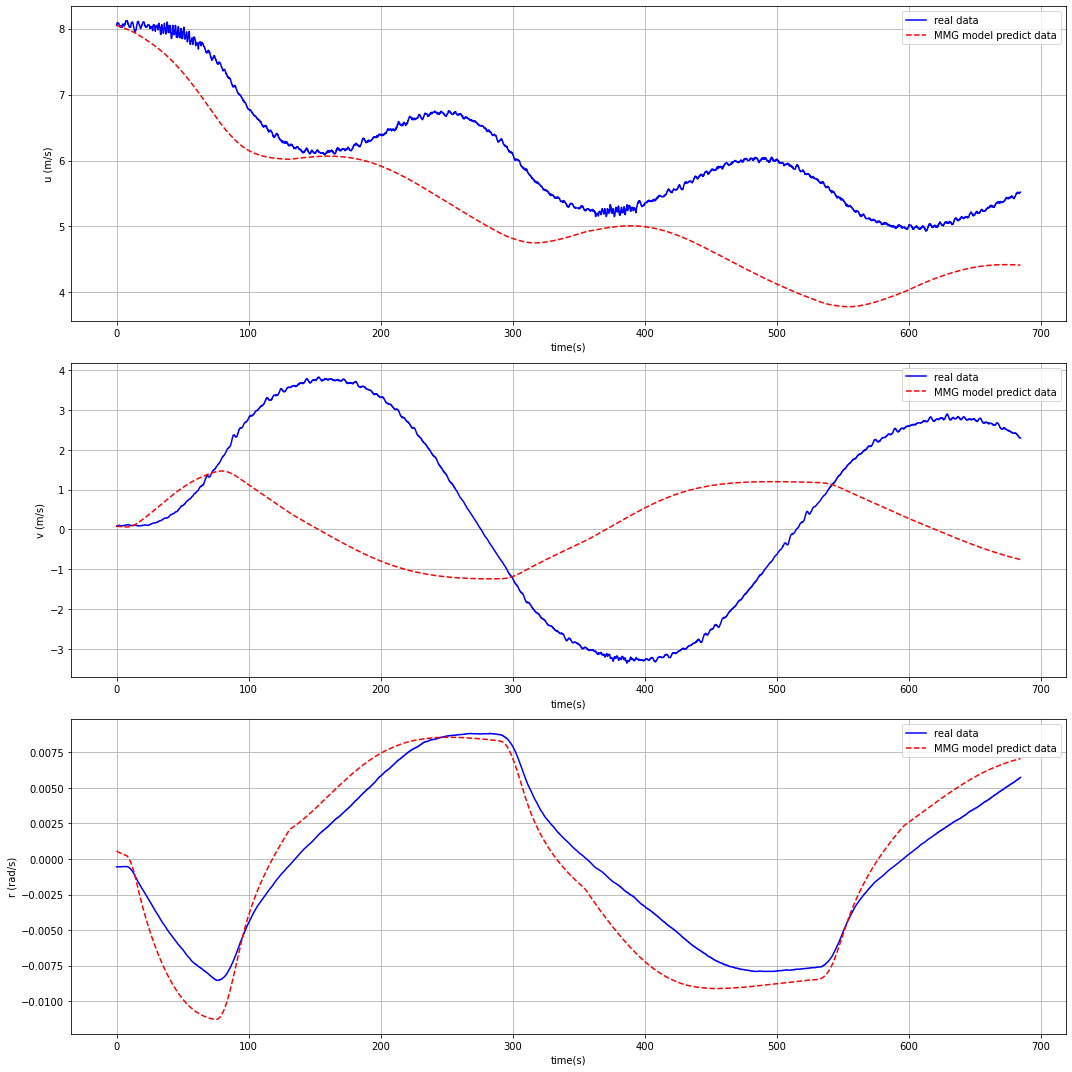

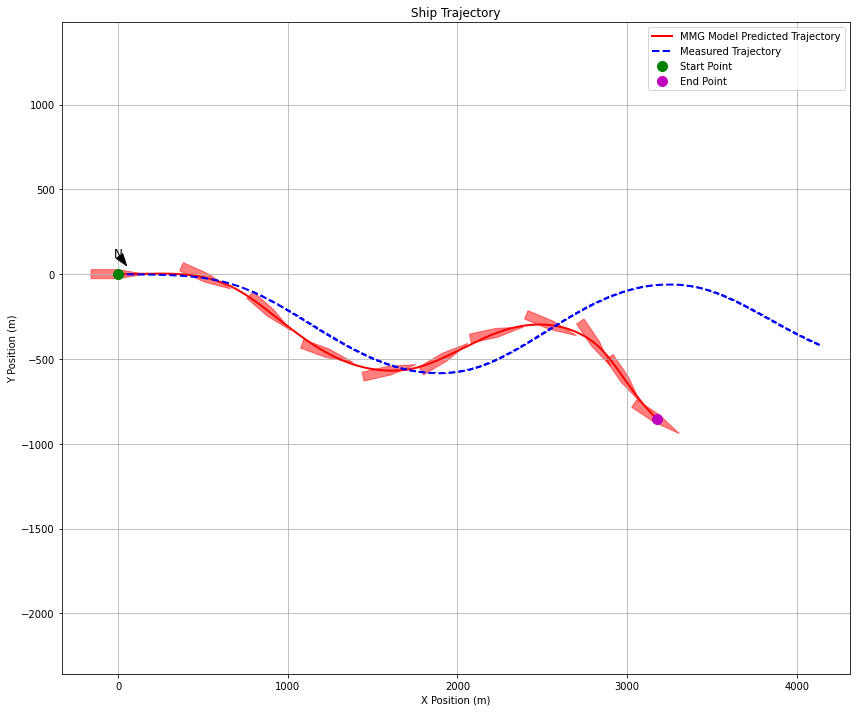

纵向速度 u RMSE: 1.0119 m/s
横向速度 v RMSE: 2.6392 m/s
艏摇角速度 r RMSE: 0.0120 rad/s
轨迹 RMSE: 1021.8323 m


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from dataclasses import dataclass
import math

@dataclass
class Vessel:
    """简化的船舶参数结构体"""
    Lpp: float  # 船长 (m)
    d: float    # 吃水 (m)
    D_p: float  # 螺旋桨直径 (m)
    displ: float  # 排水量 (m³)
    rho: float  # 水密度 (kg/m³)
    x_G: float  # 重心纵向位置 (m)
    
    # 水动力导数
    m_x_dash: float
    m_y_dash: float
    J_z_dash: float
    
    # 船体力
    X_vv_dash: float
    X_vr_dash: float
    X_rr_dash: float
    X_vvvv_dash: float
    R_0_dash: float
    
    Y_v_dash: float
    Y_r_dash: float
    Y_vvv_dash: float
    Y_vvr_dash: float
    Y_vrr_dash: float
    Y_rrr_dash: float
    
    N_v_dash: float
    N_r_dash: float
    N_vvv_dash: float
    N_vvr_dash: float
    N_vrr_dash: float
    N_rrr_dash: float
    
    # 舵参数
    a_H: float
    x_H_dash: float
    A_R: float  # 或者 A_R_Ld_em
    f_alpha: float
    t_R: float
    l_R: float
    gamma_R_plus: float
    gamma_R_minus: float
    
    # 螺旋桨参数
    w_P0: float
    t_P: float
    x_P: float
    C_1: float = None
    C_2_plus: float = None
    C_2_minus: float = None
    k_0: float = None
    k_1: float = None
    k_2: float = None
    J_slo: float = None
    J_int: float = None
    epsilon: float = 1.0
    eta: float = 1.0
    kappa: float = 1.0
    
    # 其他参数
    gamma_R: float = None
    delta_prop: float = None
    A_R_Ld_em: float = None

def mmg_dynamics(t, X, params, delta_func, nps_func):
    """
    简化的MMG模型动力学方程（静水条件）
    
    Args:
        t (float): 当前时间
        X (np.ndarray): 状态向量 [u, v_m, r, x, y, psi]
        params (Vessel): 船舶参数
        delta_func (callable): 舵角函数，输入t返回舵角
        nps_func (callable): 螺旋桨转速函数，输入t返回转速
    
    Returns:
        np.ndarray: 状态导数 [du/dt, dv_m/dt, dr/dt, dx/dt, dy/dt, dpsi/dt]
    """
    # 解包状态向量
    u, v_m, r, x, y, psi = X
    
    # 获取当前的舵角和螺旋桨转速
    delta = delta_func(t)
    nps = nps_func(t)
    
    # 简写船舶参数
    p = params
    
    # 计算总速度和无量纲化参数
    U = np.sqrt(u**2 + v_m**2)
    
    if U < 1e-6:  # 避免除以零
        beta = 0.0
        v_dash = 0.0
        r_dash = 0.0
    else:
        beta = math.atan2(-v_m, u)  # 漂角
        v_dash = v_m / U  # 无量纲横向速度
        r_dash = r * p.Lpp / U  # 无量纲艏摇角速度
    
    # 螺旋桨伴流计算
    beta_P = beta - (p.x_P / p.Lpp) * r_dash
    if all(getattr(p, k) is not None for k in ("C_1", "C_2_plus", "C_2_minus")):
        C_2 = p.C_2_plus if beta_P >= 0 else p.C_2_minus
        tmp = 1 - math.exp(-p.C_1 * abs(beta_P)) * (C_2 - 1)
        w_P = 1 - (1 - p.w_P0) * (1 + tmp)
    else:
        w_P = p.w_P0 * math.exp(-4.0 * beta_P**2)
    
    # 螺旋桨前进系数
    if abs(nps) < 1e-6:
        J = 0.0
    else:
        J = (1 - w_P) * u / (nps * p.D_p)
    
    # 螺旋桨推力系数
    if all(getattr(p, k) is not None for k in ("k_0", "k_1", "k_2")):
        K_T = p.k_0 + (p.k_1 * J) + (p.k_2 * J**2)
    else:
        K_T = p.J_slo * J + p.J_int
    
    # 舵参数计算
    beta_R = beta - p.l_R * r_dash
    
    # 流向整流系数
    if p.gamma_R is not None:
        gamma_R = p.gamma_R
    else:
        gamma_R = p.gamma_R_plus if beta_R >= 0 else p.gamma_R_minus
    
    # 舵入流速度
    v_R = U * gamma_R * beta_R
    
    if J == 0.0:
        u_R = 0.0
    else:
        u_R = u * (1 - w_P) * p.epsilon * math.sqrt(
            p.eta * (1.0 + p.kappa * (
                math.sqrt(1.0 + 8.0 * K_T / (math.pi * J**2)) - 1))**2 + (1 - p.eta)
        )
    
    # 舵入流总速度和角度
    U_R = np.sqrt(u_R**2 + v_R**2)
    
    if p.delta_prop is not None:
        alpha_R = delta - p.delta_prop - math.atan2(v_R, u_R)
    else:
        alpha_R = delta - math.atan2(v_R, u_R)
    
    # 舵的法向力
    if p.A_R is not None:
        F_N = 0.5 * p.A_R * p.rho * p.f_alpha * (U_R**2) * math.sin(alpha_R)
    else:
        F_N = 0.5 * p.A_R_Ld_em * (p.Lpp * p.d * p.rho) * p.f_alpha * (U_R**2) * math.sin(alpha_R)
    
    # 船体力
    X_H = (0.5 * p.rho * p.Lpp * p.d * (U**2) * (
        -p.R_0_dash
        + p.X_vv_dash * (v_dash**2)
        + p.X_vr_dash * v_dash * r_dash
        + p.X_rr_dash * (r_dash**2)
        + p.X_vvvv_dash * (v_dash**4)
    ))
    
    # 舵力
    X_R = -(1 - p.t_R) * F_N * math.sin(delta)
    
    # 螺旋桨力
    X_P = (1 - p.t_P) * p.rho * K_T * nps**2 * p.D_p**4
    
    # 横向船体力
    Y_H = (0.5 * p.rho * p.Lpp * p.d * (U**2) * (
        p.Y_v_dash * v_dash
        + p.Y_r_dash * r_dash
        + p.Y_vvv_dash * (v_dash**3)
        + p.Y_vvr_dash * (v_dash**2) * r_dash
        + p.Y_vrr_dash * v_dash * (r_dash**2)
        + p.Y_rrr_dash * (r_dash**3)
    ))
    
    # 横向舵力
    Y_R = -(1 + p.a_H) * F_N * math.cos(delta)
    
    # 艏摇力矩(船体)
    N_H = (0.5 * p.rho * (p.Lpp**2) * p.d * (U**2) * (
        p.N_v_dash * v_dash
        + p.N_r_dash * r_dash
        + p.N_vvv_dash * (v_dash**3)
        + p.N_vvr_dash * (v_dash**2) * r_dash
        + p.N_vrr_dash * v_dash * (r_dash**2)
        + p.N_rrr_dash * (r_dash**3)
    ))
    
    # 转为实际尺度
    x_H = p.x_H_dash * p.Lpp
    
    # 艏摇力矩(舵)
    N_R = -(-0.5 * p.Lpp + p.a_H * x_H) * F_N * math.cos(delta)
    
    # 质量矩阵计算
    m_x = p.m_x_dash * (0.5 * p.rho * (p.Lpp**2) * p.d)
    m_y = p.m_y_dash * (0.5 * p.rho * (p.Lpp**2) * p.d)
    J_z = p.J_z_dash * (0.5 * p.rho * (p.Lpp**4) * p.d)
    m = p.displ * p.rho
    I_zG = m * (0.25 * p.Lpp)**2
    
    # 刚体和附加质量矩阵
    M_RB = np.array([
        [m, 0.0, 0.0],
        [0.0, m, m * p.x_G],
        [0.0, m * p.x_G, I_zG]
    ])
    
    M_A = np.array([
        [m_x, 0.0, 0.0],
        [0.0, m_y, 0.0],
        [0.0, 0.0, J_z + (p.x_G**2) * m]
    ])
    
    M_inv = np.linalg.inv(M_RB + M_A)
    
    # 科氏力矩阵
    C_RB = np.array([
        [0.0, -m * r, -m * p.x_G * r],
        [m * r, 0.0, 0.0],
        [m * p.x_G * r, 0.0, 0.0]
    ])
    
    C_A = np.array([
        [0.0, 0.0, -m_y * v_m],
        [0.0, 0.0, m_x * u],
        [0.0, 0.0, 0.0]
    ])
    
    # 合力和力矩
    FX = X_H + X_R + X_P
    FY = Y_H + Y_R
    FN = N_H + N_R
    
    F = np.array([FX, FY, FN])
    
    # 计算加速度
    acceleration = np.dot(
        M_inv, F - np.dot((C_RB + C_A), np.array([u, v_m, r]))
    )
    
    # 计算位置和姿态的变化率
    # 将船体速度从船体坐标系转换到地理坐标系
    dx_dt = u * np.cos(psi) - v_m * np.sin(psi)
    dy_dt = u * np.sin(psi) + v_m * np.cos(psi)
    dpsi_dt = r
    
    # 返回所有状态的导数
    return np.concatenate([acceleration, [dx_dt, dy_dt, dpsi_dt]])

def simulate_mmg_model_with_trajectory(vessel, t_span, t_eval, initial_state, delta_data, nps_data, time_data):
    """
    模拟MMG模型，包括船舶轨迹
    
    Args:
        vessel (Vessel): 船舶参数
        t_span (tuple): 模拟时间范围 (t_start, t_end)
        t_eval (np.ndarray): 评估时间点
        initial_state (np.ndarray): 初始状态 [u0, v0, r0, x0, y0, psi0]
        delta_data (np.ndarray): 舵角数据
        nps_data (np.ndarray): 螺旋桨转速数据
        time_data (np.ndarray): 时间数据
    
    Returns:
        np.ndarray: 模拟结果
    """
    # 创建控制输入插值函数
    from scipy.interpolate import interp1d
    
    delta_func = interp1d(time_data, delta_data, kind='linear', fill_value='extrapolate')
    nps_func = interp1d(time_data, nps_data, kind='linear', fill_value='extrapolate')
    
    # 定义ODE右侧函数
    def ode_system(t, y):
        return mmg_dynamics(t, y, vessel, delta_func, nps_func)
    
    # 使用solve_ivp求解ODE
    solution = solve_ivp(
        ode_system,
        t_span,
        initial_state,
        t_eval=t_eval,
        method='RK45',
        rtol=1e-4,
        atol=1e-6
    )
    
    return solution.y

def compare_results(time_data, measured_data, simulated_data, labels):
    """
    比较实测数据和模拟数据
    
    Args:
        time_data (np.ndarray): 时间数据
        measured_data (np.ndarray): 实测数据，形状为(n_variables, n_samples)
        simulated_data (np.ndarray): 模拟数据，形状为(n_variables, n_samples)
        labels (list): 变量标签
    """
    n_variables = len(labels)
    
    plt.figure(figsize=(15, 5 * n_variables))
    
    for i in range(n_variables):
        plt.subplot(n_variables, 1, i+1)
        plt.plot(time_data, measured_data[i], 'b-', label='real data')
        plt.plot(time_data, simulated_data[i], 'r--', label='MMG model predict data')
        plt.xlabel('time(s)')
        plt.ylabel(labels[i])
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_trajectory(x_sim, y_sim, psi_sim, vessel, measured_x=None, measured_y=None):
    """
    绘制船舶轨迹
    
    Args:
        x_sim (np.ndarray): 模拟的x坐标数据
        y_sim (np.ndarray): 模拟的y坐标数据
        psi_sim (np.ndarray): 模拟的艏向角数据
        vessel (Vessel): 船舶参数
        measured_x (np.ndarray, optional): 实测的x坐标数据
        measured_y (np.ndarray, optional): 实测的y坐标数据
    """
    plt.figure(figsize=(12, 10))
    
    # 绘制轨迹
    plt.plot(x_sim, y_sim, 'r-', linewidth=2, label='MMG Model Predicted Trajectory')
    
    if measured_x is not None and measured_y is not None:
        plt.plot(measured_x, measured_y, 'b--', linewidth=2, label='Measured Trajectory')
    
    # 每隔一定距离绘制船舶轮廓
    ship_interval = max(1, len(x_sim) // 10)  # 绘制10个船舶轮廓
    
    for i in range(0, len(x_sim), ship_interval):
        draw_ship_outline(x_sim[i], y_sim[i], psi_sim[i], vessel.Lpp, vessel.Lpp/6, 'r', 0.5)
    
    # 标记起点和终点
    plt.plot(x_sim[0], y_sim[0], 'go', markersize=10, label='Start Point')
    plt.plot(x_sim[-1], y_sim[-1], 'mo', markersize=10, label='End Point')
    
    # 设置图形属性
    plt.axis('equal')
    plt.grid(True)
    plt.title('Ship Trajectory')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.legend()
    
    # 添加北向标记
    plt.annotate('N', xy=(x_sim[0] + 50, y_sim[0] + 50), 
                xytext=(x_sim[0], y_sim[0] + 100),
                arrowprops=dict(facecolor='black', width=1, headwidth=8),
                fontsize=12, ha='center')
    
    plt.tight_layout()
    plt.show()

def draw_ship_outline(x, y, psi, length, width, color='r', alpha=0.5):
    """
    在指定位置绘制简化的船舶轮廓
    
    Args:
        x (float): 船舶中心的x坐标
        y (float): 船舶中心的y坐标
        psi (float): 艏向角（弧度）
        length (float): 船长
        width (float): 船宽
        color (str): 轮廓颜色
        alpha (float): 透明度
    """
    # 船舶轮廓点（相对于船舶中心）
    bow_x = length / 2
    stern_x = -length / 2
    port_y = width / 2
    starboard_y = -width / 2
    
    # 船舶轮廓点的坐标（船体坐标系）
    outline_x = [bow_x, 0, stern_x, stern_x, 0, bow_x]
    outline_y = [0, starboard_y, starboard_y, port_y, port_y, 0]
    
    # 旋转并平移至世界坐标系
    world_x = []
    world_y = []
    
    for ship_x, ship_y in zip(outline_x, outline_y):
        # 旋转
        rot_x = ship_x * np.cos(psi) - ship_y * np.sin(psi)
        rot_y = ship_x * np.sin(psi) + ship_y * np.cos(psi)
        
        # 平移
        world_x.append(x + rot_x)
        world_y.append(y + rot_y)
    
    # 绘制船舶轮廓
    plt.fill(world_x, world_y, color=color, alpha=alpha)

def process_measured_trajectory(time_data, u_data, v_data, r_data, initial_heading=0.0):
    """
    根据实测的速度数据计算船舶轨迹
    
    Args:
        time_data (np.ndarray): 时间数据
        u_data (np.ndarray): 纵向速度数据
        v_data (np.ndarray): 横向速度数据
        r_data (np.ndarray): 艏摇角速度数据
        initial_heading (float): 初始艏向角（弧度）
    
    Returns:
        tuple: (x_measured, y_measured) 实测轨迹数据
    """
    dt = np.diff(time_data, prepend=time_data[0])
    
    # 初始化位置和艏向角
    x_measured = np.zeros_like(time_data)
    y_measured = np.zeros_like(time_data)
    psi = np.zeros_like(time_data)
    psi[0] = initial_heading
    
    # 积分计算轨迹
    for i in range(1, len(time_data)):
        # 更新艏向角
        psi[i] = psi[i-1] + r_data[i-1] * dt[i]
        
        # 将船体速度从船体坐标系转换到地理坐标系
        dx = (u_data[i-1] * np.cos(psi[i-1]) - v_data[i-1] * np.sin(psi[i-1])) * dt[i]
        dy = (u_data[i-1] * np.sin(psi[i-1]) + v_data[i-1] * np.cos(psi[i-1])) * dt[i]
        
        # 更新位置
        x_measured[i] = x_measured[i-1] + dx
        y_measured[i] = y_measured[i-1] + dy
    
    return x_measured, y_measured, psi

def main():
    # 加载数据集
    # 假设数据存储在CSV文件中
    df = pd.read_csv('ship_motion_data_fixed.csv')
    
    # 提取数据列
    time_data = df['time(s)'].values
    u_data = df['u(m/s)'].values
    v_data = df['v_m(m/s)'].values
    r_data = np.radians(df['yaw(deg/s)'].values)  # 转换为弧度/秒
    delta_data = np.radians(df['rudder angle(deg)'].values)  # 转换为弧度
    nps_data = df['nps(RPM)'].values / 60.0  # 转换为转/秒
    x_position = df['x-position(m)'].values
    y_position = df['y-position(m)'].values

    
    # 计算实测轨迹（从速度积分得到）
    x_measured, y_measured, psi_measured = process_measured_trajectory(time_data, u_data, v_data, r_data)
    
    # 设置船舶参数 (KVLCC2 参数示例)
    vessel = Vessel(
        Lpp=320.0,
        d=20.8,
        D_p=9.86,
        displ=312600.0,
        rho=1030.0,
        x_G=11.2,
        
        # 水动力导数
        m_x_dash=0.022,
        m_y_dash=0.223,
        J_z_dash=0.011,
        
        # 船体力
        R_0_dash=0.022,
        X_vv_dash=-0.040,
        X_vr_dash=0.002,
        X_rr_dash=0.011,
        X_vvvv_dash=0.771,
        
        Y_v_dash=-0.315,
        Y_r_dash=0.083,
        Y_vvv_dash=-1.607,
        Y_vvr_dash=0.379,
        Y_vrr_dash=-0.391,
        Y_rrr_dash=0.008,
        
        N_v_dash=-0.137,
        N_r_dash=-0.049,
        N_vvv_dash=-0.030,
        N_vvr_dash=-0.294,
        N_vrr_dash=0.055,
        N_rrr_dash=-0.013,
        
        # 舵参数
        a_H=0.312,
        x_H_dash=-0.464,
        A_R=112.5,
        f_alpha=2.747,
        t_R=0.387,
        l_R=-0.710,
        gamma_R_plus=0.640,
        gamma_R_minus=0.395,
        
        # 螺旋桨参数
        w_P0=0.35,
        t_P=0.220,
        x_P=-160.0,  # x_P=-0.480
        C_1=2.0,
        C_2_plus=1.6,
        C_2_minus=1.1,
        k_0=0.3243,
        k_1=-0.2219,
        k_2=-0.1476,
        epsilon=1.09,
        eta=0.626,
        kappa=0.5
    )
    
    # 设置模拟参数
    t_span = (time_data[0], time_data[-1])
    t_eval = time_data
    
    # 初始状态 [u0, v0, r0, x0, y0, psi0]
    initial_state = np.array([u_data[0], v_data[0], r_data[0], 0.0, 0.0, 0.0])
    
    # 运行模拟（包括轨迹）
    simulated_states = simulate_mmg_model_with_trajectory(
        vessel, t_span, t_eval, initial_state, delta_data, nps_data, time_data
    )
    
    # 提取模拟结果
    u_sim = simulated_states[0]
    v_sim = simulated_states[1]
    r_sim = simulated_states[2]
    x_sim = simulated_states[3]
    y_sim = simulated_states[4]
    psi_sim = simulated_states[5]
    
    # 比较速度结果
    measured_data = np.vstack([u_data, v_data, -r_data])
    simulated_data = np.vstack([u_sim, v_sim, r_sim])
    labels = ['u (m/s)', 'v (m/s)', 'r (rad/s)']
    
    compare_results(time_data, measured_data, simulated_data, labels)
    
    # 绘制轨迹
    plot_trajectory(x_sim, y_sim, psi_sim, vessel, x_position, -y_position)
    
    # 计算误差指标
    u_rmse = np.sqrt(np.mean((u_data - u_sim)**2))
    v_rmse = np.sqrt(np.mean((v_data - v_sim)**2))
    r_rmse = np.sqrt(np.mean((r_data - r_sim)**2))
    
    # 计算轨迹误差
    traj_rmse = np.sqrt(np.mean((x_measured - x_sim)**2 + (y_measured - y_sim)**2))
    
    print(f"纵向速度 u RMSE: {u_rmse:.4f} m/s")
    print(f"横向速度 v RMSE: {v_rmse:.4f} m/s")
    print(f"艏摇角速度 r RMSE: {r_rmse:.4f} rad/s")
    print(f"轨迹 RMSE: {traj_rmse:.4f} m")

if __name__ == "__main__":
    main()